#### Libraries used

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# CUSTOMER SEGMENTATION USING RFM

Customer Segmentation comes as one of the most important actions companies should address when they deal with a large customer base. From what we saw earlier we deduced many inisghts about our customer base as a whole but there is still much more to be done.

Customers are not the same and therefore should not be treated the same especially when the company's precious resources are on the line.

One of the most popular customer segmentation methods is RFM.

RFM stands for:
- **Recency**: *When was the last time a customer purchased anything from us?*
- **Frequency**: *How often does a customer purchase from us?*
- **Monetary**: *How much money does a customer spend on us?*

In [2]:
# Import e_commerce dataframe
e_commerce_df1 = pd.read_csv('../datasets/e_commerce_add_customer_types.csv', index_col=0)

In [3]:
e_commerce_df1['invoice_date'] = pd.to_datetime(e_commerce_df1['invoice_date'])

## Recency

In [4]:
e_commerce_df1.invoice_date.max()

Timestamp('2011-12-09 12:50:00')

How do we calculate a customer's *recency*?

Well, as per the definition above, we are looking for the last time a purchase was made from the most recent date we have which is 2011-12-09.

Therefore, we need to calculate the number of days of each purchase from this max date.

In [5]:
# Calculate the most recent purchase date of each customer
customers_df = pd.DataFrame(e_commerce_df1.groupby('customer_id').max()['invoice_date'].reset_index())

In [6]:
customers_df.rename(columns={'invoice_date':'max_invoice_date'}, inplace = True)

In [7]:
customers_df.dtypes

customer_id                  int64
max_invoice_date    datetime64[ns]
dtype: object

In [8]:
# The recency in days since a customer's last purchase from the company. The higher the less recent.
customers_df['recency'] = customers_df.max_invoice_date.max() - customers_df.max_invoice_date
customers_df.recency = customers_df.recency.dt.days

In [9]:
customers_df

,customer_id,max_invoice_date,recency
0,12346,2011-01-18 10:01:00,325
1,12347,2011-12-07 15:52:00,1
2,12348,2011-09-25 13:13:00,74
3,12349,2011-11-21 09:51:00,18
4,12350,2011-02-02 16:01:00,309
...,...,...,...
4333,18280,2011-03-07 09:52:00,277
4334,18281,2011-06-12 10:53:00,180
4335,18282,2011-12-02 11:43:00,7
4336,18283,2011-12-06 12:02:00,3


In [10]:
#Drop max_invoice_date
customers_df.drop('max_invoice_date', axis=1, inplace = True)

In [11]:
customers_df.describe()

,customer_id,recency
count,4338.000000,4338.000000
mean,15300.408022,91.536422
std,1721.808492,100.014169
min,12346.000000,0.000000
25%,13813.250000,17.000000
50%,15299.500000,50.000000
75%,16778.750000,141.000000
max,18287.000000,373.000000


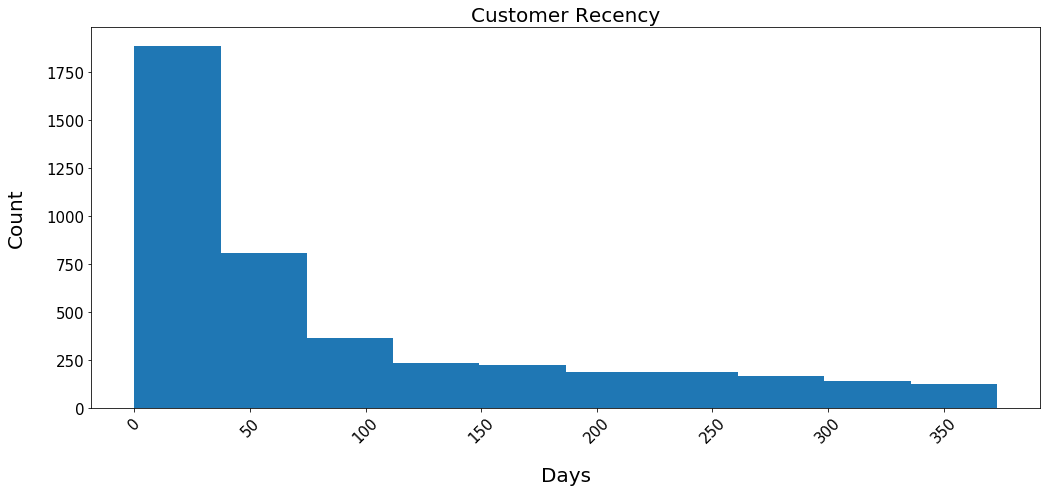

In [12]:
plt.figure(figsize=(17,7))

ax1 = customers_df.recency.hist()
ax1.set_xlabel("Days",fontsize=20, labelpad = 20)
ax1.set_ylabel("Count",fontsize=20, labelpad = 20)

plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Customer Recency', fontsize = 20)
plt.grid(False)
plt.show()

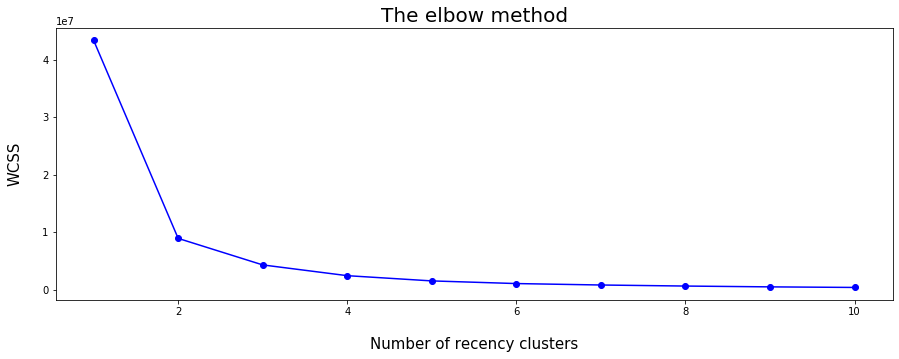

In [13]:
### We use WCSS (within cluster sum of squares) to find the optimum number of clusters for k-means classification 

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(np.array(customers_df.recency).reshape(-1, 1))
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.figure(figsize=(15,5))
ax1 = plt.plot(range(1, 11), wcss, 'bo-')
plt.title('The elbow method', fontsize = 20)
plt.xlabel('Number of recency clusters', fontsize = 15, labelpad = 20)
plt.ylabel('WCSS', fontsize = 15, labelpad = 20) #within cluster sum of squares
plt.grid(False)
plt.savefig("../images/charts/recency_elbow_k_means.png", bbox_inches='tight', dpi=300)
plt.show()

From the elbow method graph, we can tel that the optimum number of clusters would be 3 (+-1).

In [14]:
kmeans = KMeans(n_clusters=3).fit(np.array(customers_df.recency).reshape(-1, 1))
centroids = kmeans.cluster_centers_
customers_df['recency_cluster'] = kmeans.fit_predict(np.array(customers_df.recency).reshape(-1, 1))
customers_df.head()

,customer_id,recency,recency_cluster
0,12346,325,1
1,12347,1,0
2,12348,74,0
3,12349,18,0
4,12350,309,1


In [15]:
# Check all recency_clusters
customers_df.recency_cluster.value_counts()

0    2906
2     806
1     626
Name: recency_cluster, dtype: int64

In [16]:
customers_df.groupby('recency_cluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,2906.0,31.163799,25.089417,0.0,10.0,24.0,50.00,91.0
1,626.0,293.431310,45.109849,224.0,256.0,286.5,325.75,373.0
2,806.0,152.400744,38.405673,92.0,118.0,151.5,185.00,222.0


We can see that clusters '0' contains the least inactive customers while cluster '1' has the highest activity and cluster '2' is in the middle.


## Frequency

Following the same principle as recency, we need to identify the total number of orders each cutomer has made in our given timeframe.

In [17]:
customers_freq = pd.DataFrame(e_commerce_df1.groupby('customer_id').count()['invoice_no'].reset_index())

In [18]:
customers_freq.rename(columns={'invoice_no':'frequency'}, inplace = True)

In [19]:
customers_freq

,customer_id,frequency
0,12346,1
1,12347,182
2,12348,31
3,12349,73
4,12350,17
...,...,...
4333,18280,10
4334,18281,7
4335,18282,12
4336,18283,756


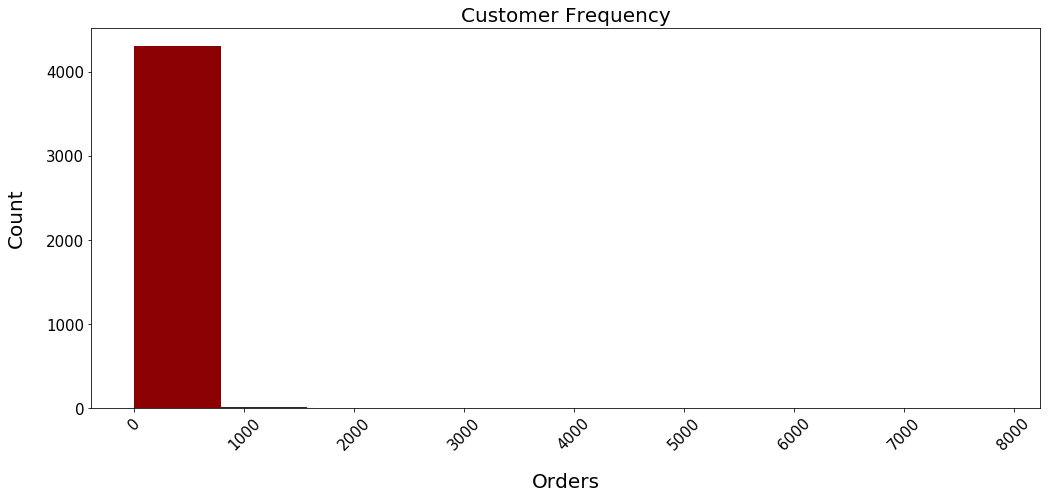

In [20]:
plt.figure(figsize=(17,7))

ax1 = customers_freq.frequency.hist(color = 'darkred')
ax1.set_xlabel("Orders",fontsize=20, labelpad = 20)
ax1.set_ylabel("Count",fontsize=20, labelpad = 20)

plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Customer Frequency', fontsize = 20)
plt.grid(False)
plt.show()

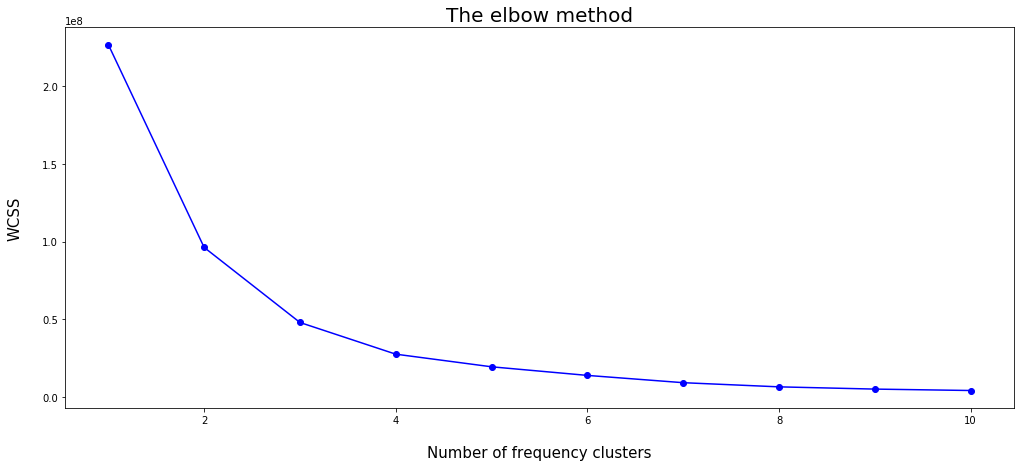

In [21]:
### We use WCSS (within cluster sum of squares) to find the optimum number of clusters for k-means classification 

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(np.array(customers_freq.frequency).reshape(-1, 1))
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.figure(figsize=(17,7))
ax1 = plt.plot(range(1, 11), wcss, 'bo-')
plt.title('The elbow method', fontsize = 20)
plt.xlabel('Number of frequency clusters', fontsize = 15, labelpad = 20)
plt.ylabel('WCSS', fontsize = 15, labelpad = 20) #within cluster sum of squares
plt.grid(False)
plt.show()

In [22]:
kmeans = KMeans(n_clusters=3).fit(np.array(customers_freq.frequency).reshape(-1, 1))
centroids = kmeans.cluster_centers_
customers_freq['frequency_cluster'] = kmeans.fit_predict(np.array(customers_freq.frequency).reshape(-1, 1))
customers_freq.head()

,customer_id,frequency,frequency_cluster
0,12346,1,0
1,12347,182,0
2,12348,31,0
3,12349,73,0
4,12350,17,0


Merge customers_freq on customers_df

In [23]:
customers_df = pd.merge(customers_df, customers_freq, on = 'customer_id')

In [24]:
customers_df.tail()

,customer_id,recency,recency_cluster,frequency,frequency_cluster
4333,18280,277,1,10,0
4334,18281,180,2,7,0
4335,18282,7,0,12,0
4336,18283,3,0,756,2
4337,18287,42,0,70,0


In [25]:
customers_df.groupby('frequency_cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,4072.0,59.639244,60.203016,1.0,16.00,37.0,85.00,281.0
1,4.0,5807.000000,1429.730044,4595.0,4982.00,5393.0,6218.00,7847.0
2,262.0,503.072519,321.281281,282.0,327.25,405.5,540.25,2700.0


We can see that clusters '0' contains the least frequenct customers while cluster '1' has the highest frequency and cluster '2' is in the middle.


## Monetary

Following the same principle as recency and frequency, we need to identify the total revenue each cutomer has made in our given timeframe.

In [26]:
customers_revenue = pd.DataFrame(e_commerce_df1.groupby('customer_id').sum()['revenue'].reset_index())

In [27]:
customers_revenue

,customer_id,revenue
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40
...,...,...
4333,18280,180.60
4334,18281,80.82
4335,18282,178.05
4336,18283,2094.88


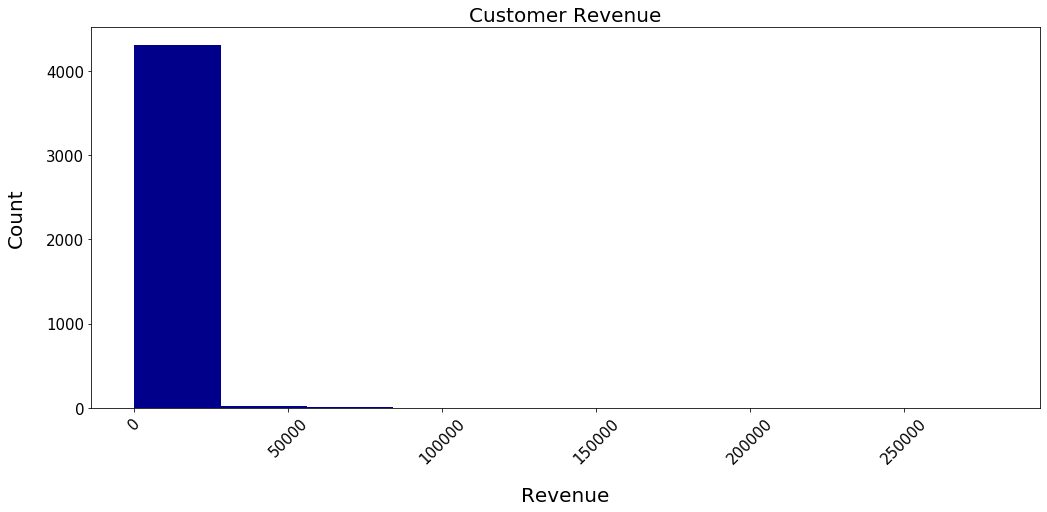

In [28]:
plt.figure(figsize=(17,7))

ax1 = customers_revenue.revenue.hist(color = 'darkblue')
ax1.set_xlabel("Revenue",fontsize=20, labelpad = 20)
ax1.set_ylabel("Count",fontsize=20, labelpad = 20)

plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Customer Revenue', fontsize = 20)
plt.grid(False)
plt.show()

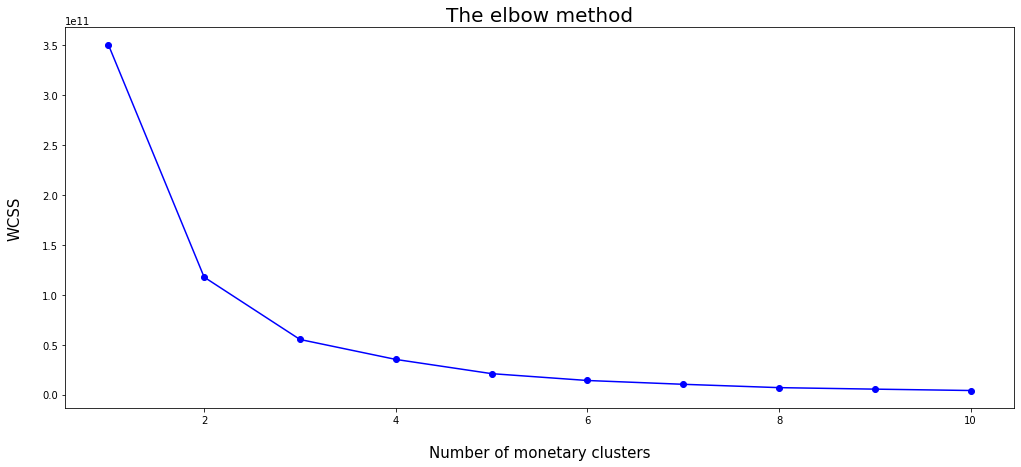

In [29]:
### We use WCSS (within cluster sum of squares) to find the optimum number of clusters for k-means classification 

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(np.array(customers_revenue.revenue).reshape(-1, 1))
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.figure(figsize=(17,7))
ax1 = plt.plot(range(1, 11), wcss, 'bo-')
plt.title('The elbow method', fontsize = 20)
plt.xlabel('Number of monetary clusters', fontsize = 15, labelpad = 20)
plt.ylabel('WCSS', fontsize = 15, labelpad = 20) #within cluster sum of squares
plt.grid(False)
plt.show()

In [30]:
kmeans = KMeans(n_clusters=3).fit(np.array(customers_revenue.revenue).reshape(-1, 1))
centroids = kmeans.cluster_centers_
customers_revenue['monetary_cluster'] = kmeans.fit_predict(np.array(customers_revenue.revenue).reshape(-1, 1))
customers_revenue.head()

,customer_id,revenue,monetary_cluster
0,12346,77183.60,2
1,12347,4310.00,0
2,12348,1797.24,0
3,12349,1757.55,0
4,12350,334.40,0


In [31]:
customers_revenue.groupby('monetary_cluster').describe()

customer_id                                               \
                       count          mean          std      min      25%   
monetary_cluster                                                            
0                     4307.0  15300.182958  1721.891593  12347.0  13812.5   
1                        5.0  16311.000000  1521.138718  14646.0  14911.0   
2                       26.0  15143.346154  1739.742026  12346.0  13870.5   

                                             revenue                 \
                      50%       75%      max   count           mean   
monetary_cluster                                                      
0                 15299.0  16779.50  18287.0  4307.0    1480.796985   
1                 16446.0  17450.00  18102.0     5.0  209342.334000   
2                 15204.5  16323.75  17949.0    26.0   57188.600769   

                                                                   \
                           std        min          25%        50%   
monetary_cluster                                                    
0                  2463.849989       3.75     306.5050     665.86   
1                 58598.003581  143825.06  168472.5000  194550.79   
2                 24729.928330   31833.68   37844.5125   53030.72   

                                          
                          75%        max  
monetary_cluster                          
0                   1624.6300   28882.44  
1                 259657.3000  280206.02  
2                  65133.4975  124914.53

In [32]:
customers_df = pd.merge(customers_df, customers_revenue, on = 'customer_id')

In [33]:
customers_df

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,monetary_cluster
0,12346,325,1,1,0,77183.60,2
1,12347,1,0,182,0,4310.00,0
2,12348,74,0,31,0,1797.24,0
3,12349,18,0,73,0,1757.55,0
4,12350,309,1,17,0,334.40,0
...,...,...,...,...,...,...,...
4333,18280,277,1,10,0,180.60,0
4334,18281,180,2,7,0,80.82,0
4335,18282,7,0,12,0,178.05,0
4336,18283,3,0,756,2,2094.88,0


In [34]:
customers_df.groupby('monetary_cluster')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
0,4307.0,1480.796985,2463.849989,3.75,306.5050,665.86,1624.6300,28882.44
1,5.0,209342.334000,58598.003581,143825.06,168472.5000,194550.79,259657.3000,280206.02
2,26.0,57188.600769,24729.928330,31833.68,37844.5125,53030.72,65133.4975,124914.53


We can see that clusters '0' contains the least revenue customers while cluster '1' has the highest frequency and cluster '2' is in the middle.


# Main cluster based on highest value

We need to create one cluster based on the three different cluster types in order to give high/ value to customers.

High value would be a customer that has low recency, high frequency, and high monetary.

For this, our main cluster would be the sum of the cluster number based on the values mentioned above.

We can see that the cluster numbers are not coherent in the sense that cluster order does not follow the logical progression of their corresponding minimums.

We need to manually fix that.

#### Recency cluster

In [35]:
customers_df.groupby('recency_cluster').describe()['recency']

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,2906.0,31.163799,25.089417,0.0,10.0,24.0,50.00,91.0
1,626.0,293.431310,45.109849,224.0,256.0,286.5,325.75,373.0
2,806.0,152.400744,38.405673,92.0,118.0,151.5,185.00,222.0


Best cluster would be the one with the least min and so on. Therefore we reclassfiy cluster numbers.

In [36]:
customers_df.replace({'recency_cluster': {0:3, 2:4, 1:5}}, inplace = True)

In [37]:
customers_df.groupby('recency_cluster').describe()['recency']

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
3,2906.0,31.163799,25.089417,0.0,10.0,24.0,50.00,91.0
4,806.0,152.400744,38.405673,92.0,118.0,151.5,185.00,222.0
5,626.0,293.431310,45.109849,224.0,256.0,286.5,325.75,373.0


Now cluster 5 is the one with the most recent customers.

We apply the same principle to the rest of the clusters.

In [38]:
customers_df.groupby('frequency_cluster').describe()['frequency']

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,4072.0,59.639244,60.203016,1.0,16.00,37.0,85.00,281.0
1,4.0,5807.000000,1429.730044,4595.0,4982.00,5393.0,6218.00,7847.0
2,262.0,503.072519,321.281281,282.0,327.25,405.5,540.25,2700.0


In [39]:
# We need the cluster with the highest minimum to be in cluster 5
customers_df.replace({'frequency_cluster': {0:3, 1:5, 2:4}}, inplace = True)

In [40]:
customers_df.groupby('frequency_cluster').describe()['frequency']

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
3,4072.0,59.639244,60.203016,1.0,16.00,37.0,85.00,281.0
4,262.0,503.072519,321.281281,282.0,327.25,405.5,540.25,2700.0
5,4.0,5807.000000,1429.730044,4595.0,4982.00,5393.0,6218.00,7847.0


In [41]:
customers_df.groupby('monetary_cluster').describe()['revenue']

,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
0,4307.0,1480.796985,2463.849989,3.75,306.5050,665.86,1624.6300,28882.44
1,5.0,209342.334000,58598.003581,143825.06,168472.5000,194550.79,259657.3000,280206.02
2,26.0,57188.600769,24729.928330,31833.68,37844.5125,53030.72,65133.4975,124914.53


In [42]:
# We need the cluster with the highest minimum to be in cluster 5
customers_df.replace({'monetary_cluster': {0:3, 1:5, 2:4}}, inplace = True)

In [43]:
customers_df.groupby('monetary_cluster').describe()['revenue']

,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
3,4307.0,1480.796985,2463.849989,3.75,306.5050,665.86,1624.6300,28882.44
4,26.0,57188.600769,24729.928330,31833.68,37844.5125,53030.72,65133.4975,124914.53
5,5.0,209342.334000,58598.003581,143825.06,168472.5000,194550.79,259657.3000,280206.02


In [44]:
customers_df.tail()

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,monetary_cluster
4333,18280,277,5,10,3,180.60,3
4334,18281,180,4,7,3,80.82,3
4335,18282,7,3,12,3,178.05,3
4336,18283,3,3,756,4,2094.88,3
4337,18287,42,3,70,3,1837.28,3


## Create main cluster

In [45]:
# Main cluster can be the sum of all clusters
customers_df['main_cluster'] = customers_df.recency_cluster + customers_df.frequency_cluster + customers_df.monetary_cluster


Now we group by main_cluster and identify the average of recency, frequency, and revenue per main customer cluster in order to identify more valuable customers.

In [46]:
 customers_df.groupby('main_cluster')['recency', 'frequency', 'revenue'].mean()

,recency,frequency,revenue
main_cluster,,,
9,33.051613,74.156357,1522.921470
10,119.199430,141.398860,2406.991169
11,286.773438,42.514063,1904.255875
12,104.666667,2300.555556,111266.590000
13,0.000000,5675.000000,143825.060000


We can see that cluster 15 has the most valuable customers while cluster 9 has the lowest value customers.

In [47]:
# Customer distribution accross clsuters
pd.DataFrame(customers_df.groupby('main_cluster')['customer_id'].nunique())

,customer_id
main_cluster,
9,2635
10,1053
11,640
12,9
13,1


As per the distribution above, we can simplify it by segmenting customers to low, medium, and high value.

In [48]:
customers_df['customer_segment'] = 'low_value'
customers_df.loc[customers_df['main_cluster'] > 10,'customer_segment'] = 'medium_value' 
customers_df.loc[customers_df['main_cluster'] > 12,'customer_segment'] = 'high_value' 

In [49]:
customers_df

,customer_id,recency,recency_cluster,frequency,frequency_cluster,revenue,monetary_cluster,main_cluster,customer_segment
0,12346,325,5,1,3,77183.60,4,12,medium_value
1,12347,1,3,182,3,4310.00,3,9,low_value
2,12348,74,3,31,3,1797.24,3,9,low_value
3,12349,18,3,73,3,1757.55,3,9,low_value
4,12350,309,5,17,3,334.40,3,11,medium_value
...,...,...,...,...,...,...,...,...,...
4333,18280,277,5,10,3,180.60,3,11,medium_value
4334,18281,180,4,7,3,80.82,3,10,low_value
4335,18282,7,3,12,3,178.05,3,9,low_value
4336,18283,3,3,756,4,2094.88,3,10,low_value


Now we have a customer segmentation result that differentiates customers based on their provided value.

From this we can very much direct company resources to better suit each customer segment.

## Plot RFM segments

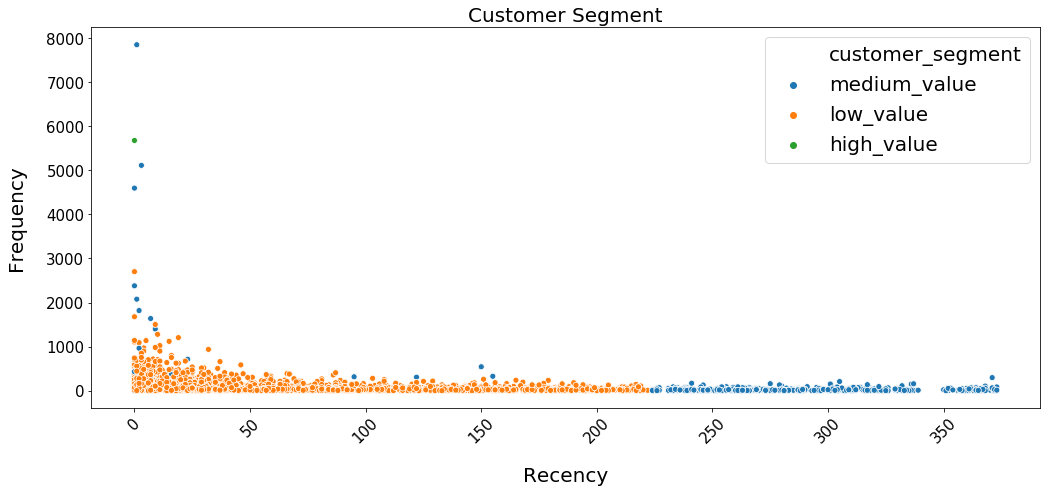

In [54]:
plt.figure(figsize=(17,7))

ax1 = sns.scatterplot(x="recency", y="frequency",hue="customer_segment", data=customers_df)
ax1.set_xlabel("Recency",fontsize=20, labelpad = 20)
ax1.set_ylabel("Frequency",fontsize=20, labelpad = 20)

plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Customer Segment', fontsize = 20)
plt.grid(False)
plt.legend(fontsize=20)
plt.savefig("../images/charts/recency_frequency_scatter.png", bbox_inches='tight', dpi=300)
plt.show()

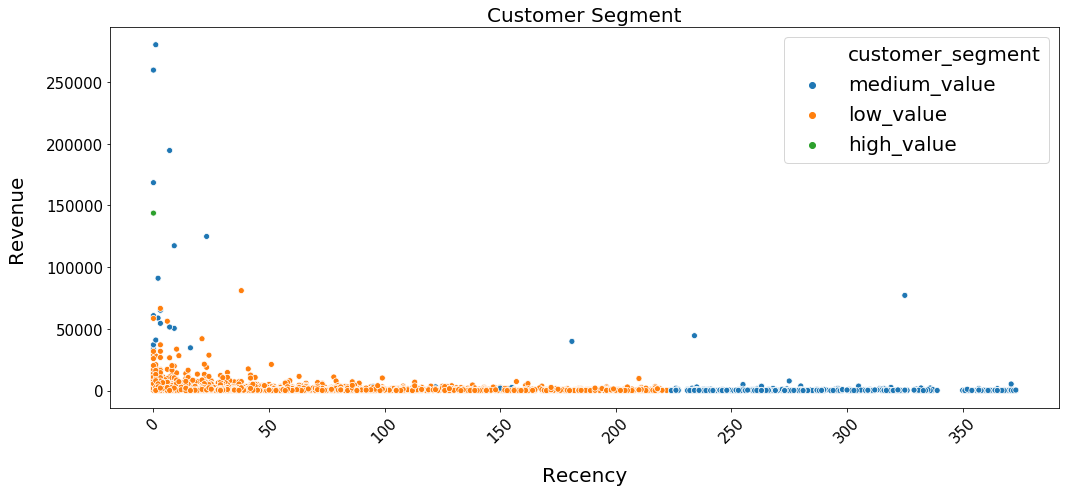

In [55]:
plt.figure(figsize=(17,7))

ax1 = sns.scatterplot(x="recency", y="revenue",hue="customer_segment", data=customers_df)
ax1.set_xlabel("Recency",fontsize=20, labelpad = 20)
ax1.set_ylabel("Revenue",fontsize=20, labelpad = 20)

plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Customer Segment', fontsize = 20)
plt.grid(False)
plt.legend(fontsize=20)
plt.savefig("../images/charts/recency_revenue_scatter.png", bbox_inches='tight', dpi=300)
plt.show()

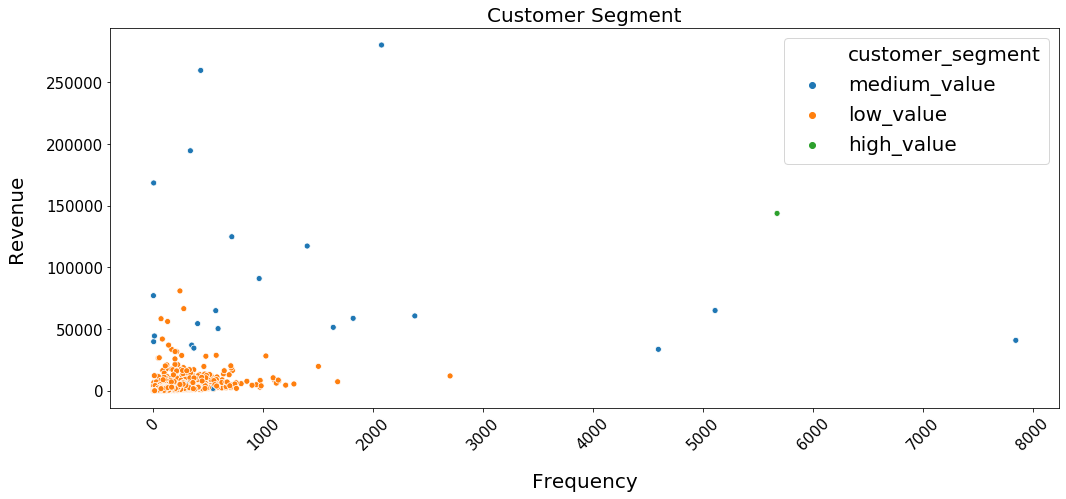

In [56]:
plt.figure(figsize=(17,7))

ax1 = sns.scatterplot(x="frequency", y="revenue",hue="customer_segment", data=customers_df)
ax1.set_xlabel("Frequency",fontsize=20, labelpad = 20)
ax1.set_ylabel("Revenue",fontsize=20, labelpad = 20)

plt.xticks(rotation = 45, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Customer Segment', fontsize = 20)
plt.grid(False)
plt.legend(fontsize=20)
plt.savefig("../images/charts/frequency_revenue_scatter.png", bbox_inches='tight', dpi=300)
plt.show()


The scatter plots clearly differentiates the assigned customer segments and reinforces the used method to segment.

From here the company can leverage their strengths based on customer segments. For example, low value customers can be targeted to increase their frequency while medium to high value customers can be targeted to improve retention.